# Objective Non-Motor Data Integration (PPMI)
This notebook loads multiple objective assessment tables, creates a common visit-level key (PATNO_EVENT = PATNO + EVENT_ID), cleans each table (drop missing rows, keep last duplicate), merges datasets using an inner join, and exports:

Raw merged dataset (not normalized)

Z-score normalized dataset (numeric columns only)

## 1. Setup

In [26]:
# ------------------------------
# 1) Libraries + small helper functions
# ------------------------------

import numpy as np                     # numerical computing
import pandas as pd                    # dataframes (read, clean, merge)
import matplotlib.pyplot as plt        # plotting
import seaborn as sns                  # nicer statistical plots

# Optional: nicer default plot style (safe to keep in notebooks)
sns.set_theme(style="whitegrid")


def show_value_counts(df: pd.DataFrame, column: str, dropna: bool = False, top_n: int | None = None):
    """
    Print value counts of a column.
    - dropna=False keeps NaN counts hidden (default pandas behavior)
    - top_n shows only the top N most common values (useful for long columns)
    """
    if column not in df.columns:
        raise KeyError(f"Column '{column}' not found. Available columns: {list(df.columns)[:10]} ...")

    vc = df[column].value_counts(dropna=dropna)
    if top_n is not None:
        vc = vc.head(top_n)
    print(vc)


def show_count_of_value(df: pd.DataFrame, column: str, value):
    """
    Print the count of one specific value in a column.
    Uses safe lookup (returns 0 if value doesn't exist).
    """
    if column not in df.columns:
        raise KeyError(f"Column '{column}' not found.")
    count = df[column].value_counts(dropna=False).get(value, 0)
    print(count)


def show_nan_count(df: pd.DataFrame, column: str):
    """Print number of missing (NaN) values in a column."""
    if column not in df.columns:
        raise KeyError(f"Column '{column}' not found.")
    print(df[column].isna().sum())


def drop_missing_rows(df: pd.DataFrame, subset: list[str] | None = None):
    """
    Drop rows with missing values.
    - subset=None drops rows that have NaN anywhere
    - subset=['col1','col2'] drops only if those columns have NaN
    """
    return df.dropna(subset=subset)


def concat_rows(df1: pd.DataFrame, df2: pd.DataFrame, reset_index: bool = True):
    """
    Stack two dataframes row-wise (axis=0).
    reset_index=True gives a clean 0..N index (usually best for integration work).
    """
    out = pd.concat([df1, df2], axis=0, ignore_index=reset_index)
    return out

def clean_for_integration(
    df: pd.DataFrame,
    name: str,
    key_cols: list[str] = ["PATNO", "EVENT_ID"],
    make_key: bool = True,
    key_name: str = "PATNO_EVENT",
    keep_cols: list[str] | None = None,
    dropna_subset: list[str] | None = None,
    keep: str = "last",
    sort_by: str | None = None
) -> pd.DataFrame:
    """
    Clean a dataset for integration (NaN first, then duplicates keep last):
    - optionally creates PATNO_EVENT from PATNO + EVENT_ID
    - optionally selects columns (keep_cols)
    - drops NaNs first
    - then drops duplicates (keep last)
    - prints a small QC summary

    Parameters
    ----------
    dropna_subset:
        - None -> drop NaNs only in key (recommended for integration)
        - list of columns -> drop rows if NaN in any of those columns
        - "ALL" -> drop rows with NaN anywhere (complete-case)

    sort_by:
        - optional column name to sort before dropping duplicates.
          Useful if you want "last entry" based on a timestamp/date column.
    """
    df = df.copy()
    before_rows = df.shape[0]

    # --- basic column checks
    for c in key_cols:
        if c not in df.columns:
            raise KeyError(f"[{name}] Missing required key column: {c}")

    # --- create integration key
    if make_key:
        df[key_name] = (
            df[key_cols[0]].astype(str).str.strip() + "_" +
            df[key_cols[1]].astype(str).str.strip()
        )
        dedup_cols = [key_name]
    else:
        dedup_cols = key_cols

    # --- select columns (if provided)
    if keep_cols is not None:
        missing = [c for c in keep_cols if c not in df.columns]
        if missing:
            raise KeyError(f"[{name}] Missing keep_cols: {missing}")
        df = df[keep_cols].copy()

    # --- drop NaNs FIRST
    if dropna_subset == "ALL":
        df = df.dropna()
        na_rule = "drop NaN anywhere (complete-case)"
    else:
        if dropna_subset is None:
            dropna_subset = dedup_cols  # default: enforce only key non-missing
            na_rule = f"drop NaN only in key ({dedup_cols})"
        else:
            na_rule = f"drop NaN in subset {dropna_subset}"
        df = df.dropna(subset=dropna_subset)

    # --- optional sort (so 'keep=last' is meaningful)
    if sort_by is not None:
        if sort_by not in df.columns:
            raise KeyError(f"[{name}] sort_by column '{sort_by}' not found.")
        df = df.sort_values(by=sort_by)

    # --- drop duplicates SECOND (keep last)
    dup_before = df.duplicated(subset=dedup_cols).sum()
    df = df.drop_duplicates(subset=dedup_cols, keep=keep)
    dup_after = df.duplicated(subset=dedup_cols).sum()

    after_rows = df.shape[0]

    # --- small QC report
    print(f"\n[{name}] Cleaning report")
    print(f"Rows: {before_rows} -> {after_rows} (removed {before_rows - after_rows})")
    print(f"NaN rule (applied first): {na_rule}")
    print(f"Duplicates on {dedup_cols} (removed after NaN drop): {dup_before} -> {dup_after}")
    if sort_by is not None:
        print(f"Sorted by '{sort_by}' before dropping duplicates (keep='{keep}').")
    else:
        print(f"Dropped duplicates with keep='{keep}' (file order used).")

    # remaining missingness snapshot
    missing_after = df.isna().sum().sort_values(ascending=False)
    if (missing_after > 0).any():
        print("Remaining missing (top 5):")
        print(missing_after[missing_after > 0].head(5))
    else:
        print("Remaining missing: none")

    return df

## 2. Load data

In [27]:
# ------------------------------
# 2) Data fetching (load raw CSV files)
# ------------------------------

# Tip: keep all file paths in one dictionary so it's easy to update later
DATA_FILES = {
    "Benton": "data/Benton_Judgement_of_Line_Orientation_29Sep2025.csv",
    "Hopkins": "data/Hopkins_Verbal_Learning_Test_-_Revised_29Sep2025.csv",
    "LNS": "data/Letter_-_Number_Sequencing_29Sep2025.csv",
    "SFT": "data/Modified_Semantic_Fluency_29Sep2025.csv",
    "MoCA": "data/Montreal_Cognitive_Assessment__MoCA__29Sep2025.csv",
    "SDMT": "data/Symbol_Digit_Modalities_Test_29Sep2025.csv",
    "MDS_III": "data/Assessed(Objective)_MDS-UPDRS_Part_III_28Sep2025.csv",
}

def load_csv(path: str) -> pd.DataFrame:
    """
    Small wrapper to read CSV consistently.
    (You can add dtype/date parsing later if needed.)
    """
    return pd.read_csv(path, encoding="utf-8", low_memory=False)

# Load each dataset
df_Benton = load_csv(DATA_FILES["Benton"])
df_Hopkins = load_csv(DATA_FILES["Hopkins"])
df_LNS = load_csv(DATA_FILES["LNS"])
df_SFT = load_csv(DATA_FILES["SFT"])
df_MoCA = load_csv(DATA_FILES["MoCA"])
df_SDMT = load_csv(DATA_FILES["SDMT"])
df_MDS_III = load_csv(DATA_FILES["MDS_III"])

# Quick sanity check: show shapes so you know files loaded correctly
print("Loaded datasets (rows, cols):")
print("Benton :", df_Benton.shape)
print("Hopkins:", df_Hopkins.shape)
print("LNS    :", df_LNS.shape)
print("SFT    :", df_SFT.shape)
print("MoCA   :", df_MoCA.shape)
print("SDMT   :", df_SDMT.shape)
print("MDS-III:", df_MDS_III.shape)

Loaded datasets (rows, cols):
Benton : (16402, 43)
Hopkins: (16452, 20)
LNS    : (16410, 31)
SFT    : (16456, 13)
MoCA   : (17142, 35)
SDMT   : (16411, 12)
MDS-III: (34772, 65)


## 3. Clean per dataset

### For each assessment file

1. Create `PATNO_EVENT` from `PATNO` and `EVENT_ID`
2. Compute/transform selected features (including reverse scoring where needed)
3. Keep only required columns
4. Drop missing rows and remove duplicates (keep last)

In [32]:
# ------------------------------
# 1) Benton JLO (Judgement of Line Orientation)
#    Feature count: 1 (JLO_TOTRAW)
# ------------------------------

df_Benton = load_csv(DATA_FILES["Benton"])

print("Benton columns (first 25):")
print(list(df_Benton.columns)[:25])
print(f"Total columns: {df_Benton.shape[1]}")

# Create integration key
df_Benton["PATNO_EVENT"] = (
    df_Benton["PATNO"].astype(str).str.strip() + "_" +
    df_Benton["EVENT_ID"].astype(str).str.strip()
)

# Reverse scoring (as you did): 15 - raw score
# (Keep numeric-safe conversion to avoid string issues)
df_Benton["JLO_TOTRAW"] = pd.to_numeric(df_Benton["JLO_TOTRAW"], errors="coerce")
df_Benton["JLO_TOTRAW"] = 15 - df_Benton["JLO_TOTRAW"]

# Keep only required columns
benton_cols = ["PATNO_EVENT", "JLO_TOTRAW"]

df_Benton_clean = clean_for_integration(
    df=df_Benton,
    name="Benton JLO",
    keep_cols=benton_cols,
    dropna_subset="ALL",   # drops NaN anywhere first
    keep="last"            # keeps last duplicate entry
)

print("Original (selected):", df_Benton[benton_cols].shape)
print("Cleaned:", df_Benton_clean.shape)

df_Benton_clean.head()

Benton columns (first 25):
['REC_ID', 'PATNO', 'EVENT_ID', 'PAG_NAME', 'INFODT', 'BENTONVERSION', 'BJLOT1', 'BJLOT2', 'BJLOT3', 'BJLOT4', 'BJLOT5', 'BJLOT6', 'BJLOT7', 'BJLOT8', 'BJLOT9', 'BJLOT10', 'BJLOT11', 'BJLOT12', 'BJLOT13', 'BJLOT14', 'BJLOT15', 'BJLOT16', 'BJLOT17', 'BJLOT18', 'BJLOT19']
Total columns: 43

[Benton JLO] Cleaning report
Rows: 16402 -> 16383 (removed 19)
NaN rule (applied first): drop NaN anywhere (complete-case)
Duplicates on ['PATNO_EVENT'] (removed after NaN drop): 0 -> 0
Dropped duplicates with keep='last' (file order used).
Remaining missing: none
Original (selected): (16402, 2)
Cleaned: (16383, 2)


,PATNO_EVENT,JLO_TOTRAW
0,3000_BL,0.0
1,3000_V04,0.0
2,3000_V06,1.0
3,3000_V08,2.0
4,3000_V10,1.0


In [33]:
# ------------------------------
# 2) Hopkins Verbal Learning Test - Revised (HVLT-R)
#    Feature count: 4 (derived)
# ------------------------------

df_Hopkins = load_csv(DATA_FILES["Hopkins"])

print("Hopkins columns (first 25):")
print(list(df_Hopkins.columns)[:25])
print(f"Total columns: {df_Hopkins.shape[1]}")

# Create integration key
df_Hopkins["PATNO_EVENT"] = (
    df_Hopkins["PATNO"].astype(str).str.strip() + "_" +
    df_Hopkins["EVENT_ID"].astype(str).str.strip()
)

# Convert needed columns to numeric (prevents string/NaN issues during math)
need_num = ["HVLTRT1", "HVLTRT2", "HVLTRT3", "HVLTRDLY", "HVLTREC", "HVLTFPRL", "HVLTFPUN"]
for c in need_num:
    df_Hopkins[c] = pd.to_numeric(df_Hopkins[c], errors="coerce")

# Helper: total learning trials
df_Hopkins["HVLTR_TOTAL"] = df_Hopkins[["HVLTRT1", "HVLTRT2", "HVLTRT3"]].sum(axis=1)

# Reverse / transform as you did
df_Hopkins["DVT_TOTAL_RECALL"]   = 36 - df_Hopkins["HVLTR_TOTAL"]
df_Hopkins["DVT_DELAYED_RECALL"] = 12 - df_Hopkins["HVLTRDLY"]

# Retention: 100 - (delayed / total) * 100
# Protect against divide-by-zero: if HVLTR_TOTAL == 0, retention becomes NaN
df_Hopkins["DVT_RETENTION"] = 100 - (df_Hopkins["HVLTRDLY"] / df_Hopkins["HVLTR_TOTAL"]) * 100
df_Hopkins.loc[df_Hopkins["HVLTR_TOTAL"] == 0, "DVT_RETENTION"] = np.nan

df_Hopkins["DVT_RECOG_DISC_INDEX"] = 12 - (
    df_Hopkins["HVLTREC"] - df_Hopkins["HVLTFPRL"] - df_Hopkins["HVLTFPUN"]
)

# Keep only required columns
hopkins_cols = [
    "PATNO_EVENT",
    "DVT_TOTAL_RECALL",
    "DVT_DELAYED_RECALL",
    "DVT_RETENTION",
    "DVT_RECOG_DISC_INDEX",
]

df_Hopkins_clean = clean_for_integration(
    df=df_Hopkins,
    name="Hopkins HVLT-R",
    keep_cols=hopkins_cols,
    dropna_subset="ALL",   # drops NaN anywhere first
    keep="last"            # keeps last duplicate entry
)

print("Original (selected):", df_Hopkins[hopkins_cols].shape)
print("Cleaned:", df_Hopkins_clean.shape)

df_Hopkins_clean.head()

Hopkins columns (first 25):
['REC_ID', 'PATNO', 'EVENT_ID', 'PAG_NAME', 'INFODT', 'HVLTRT1', 'HVLTRT2', 'HVLTRT3', 'HVLTRDLY', 'HVLTREC', 'HVLTFPRL', 'HVLTFPUN', 'HVLTVRSN', 'AGE_ASSESS_HVLT', 'DVT_TOTAL_RECALL', 'DVT_DELAYED_RECALL', 'DVT_RETENTION', 'DVT_RECOG_DISC_INDEX', 'ORIG_ENTRY', 'LAST_UPDATE']
Total columns: 20

[Hopkins HVLT-R] Cleaning report
Rows: 16452 -> 16389 (removed 63)
NaN rule (applied first): drop NaN anywhere (complete-case)
Duplicates on ['PATNO_EVENT'] (removed after NaN drop): 0 -> 0
Dropped duplicates with keep='last' (file order used).
Remaining missing: none
Original (selected): (16452, 5)
Cleaned: (16389, 5)


,PATNO_EVENT,DVT_TOTAL_RECALL,DVT_DELAYED_RECALL,DVT_RETENTION,DVT_RECOG_DISC_INDEX
0,3000_BL,6.0,2.0,66.666667,0.0
1,3000_V04,10.0,2.0,61.538462,2.0
2,3000_V06,8.0,2.0,64.285714,1.0
3,3000_V08,8.0,1.0,60.714286,2.0
4,3000_V10,6.0,2.0,66.666667,0.0


In [34]:
# ------------------------------
# 3) Letter-Number Sequencing (LNS)
#    Feature count: 1 (LNS_TOTRAW)
# ------------------------------

df_LNS = load_csv(DATA_FILES["LNS"])

print("LNS columns (first 25):")
print(list(df_LNS.columns)[:25])
print(f"Total columns: {df_LNS.shape[1]}")

# Create integration key
df_LNS["PATNO_EVENT"] = (
    df_LNS["PATNO"].astype(str).str.strip() + "_" +
    df_LNS["EVENT_ID"].astype(str).str.strip()
)

# Numeric-safe conversion + reverse scoring (as you did): 21 - raw
df_LNS["LNS_TOTRAW"] = pd.to_numeric(df_LNS["LNS_TOTRAW"], errors="coerce")
df_LNS["LNS_TOTRAW"] = 21 - df_LNS["LNS_TOTRAW"]

# Keep only required columns
lns_cols = ["PATNO_EVENT", "LNS_TOTRAW"]

df_LNS_clean = clean_for_integration(
    df=df_LNS,
    name="LNS",
    keep_cols=lns_cols,
    dropna_subset="ALL",   # drops NaN anywhere first
    keep="last"            # keeps last duplicate entry
)

print("Original (selected):", df_LNS[lns_cols].shape)
print("Cleaned:", df_LNS_clean.shape)

df_LNS_clean.head()

LNS columns (first 25):
['REC_ID', 'PATNO', 'EVENT_ID', 'PAG_NAME', 'INFODT', 'LNS1A', 'LNS1B', 'LNS1C', 'LNS2A', 'LNS2B', 'LNS2C', 'LNS3A', 'LNS3B', 'LNS3C', 'LNS4A', 'LNS4B', 'LNS4C', 'LNS5A', 'LNS5B', 'LNS5C', 'LNS6A', 'LNS6B', 'LNS6C', 'LNS7A', 'LNS7B']
Total columns: 31

[LNS] Cleaning report
Rows: 16410 -> 16410 (removed 0)
NaN rule (applied first): drop NaN anywhere (complete-case)
Duplicates on ['PATNO_EVENT'] (removed after NaN drop): 0 -> 0
Dropped duplicates with keep='last' (file order used).
Remaining missing: none
Original (selected): (16410, 2)
Cleaned: (16410, 2)


,PATNO_EVENT,LNS_TOTRAW
0,3000_BL,7
1,3000_V04,7
2,3000_V06,8
3,3000_V08,8
4,3000_V10,10


In [40]:
# ------------------------------
# 4) Modified Semantic Fluency Test (SFT)
#    Feature count: 3 (VLTANIM, VLTVEG, VLTFRUIT)
# ------------------------------

df_SFT = load_csv(DATA_FILES["SFT"])

print("SFT columns (first 25):")
print(list(df_SFT.columns)[:25])
print(f"Total columns: {df_SFT.shape[1]}")

# Create integration key
df_SFT["PATNO_EVENT"] = (
    df_SFT["PATNO"].astype(str).str.strip() + "_" +
    df_SFT["EVENT_ID"].astype(str).str.strip()
)

# Keep only required columns
sft_cols = ["PATNO_EVENT", "VLTANIM"]

# Convert to numeric + reverse scoring (as you did): 60 - raw
for c in ["VLTANIM", "VLTVEG", "VLTFRUIT"]:
    df_SFT[c] = pd.to_numeric(df_SFT[c], errors="coerce")
    df_SFT[c] = 60 - df_SFT[c]

df_SFT_clean = clean_for_integration(
    df=df_SFT,
    name="Semantic Fluency (SFT)",
    keep_cols=sft_cols,
    dropna_subset="ALL",   # drops NaN anywhere first
    keep="last"            # keeps last duplicate entry
)

print("Original (selected):", df_SFT[sft_cols].shape)
print("Cleaned:", df_SFT_clean.shape)

df_SFT_clean.head()

SFT columns (first 25):
['REC_ID', 'PATNO', 'EVENT_ID', 'PAG_NAME', 'INFODT', 'VLTANIM', 'VLTVEG', 'VLTFRUIT', 'AGE_ASSESS_SFTANIM', 'DVS_SFTANIM', 'DVT_SFTANIM', 'ORIG_ENTRY', 'LAST_UPDATE']
Total columns: 13

[Semantic Fluency (SFT)] Cleaning report
Rows: 16456 -> 16456 (removed 0)
NaN rule (applied first): drop NaN anywhere (complete-case)
Duplicates on ['PATNO_EVENT'] (removed after NaN drop): 0 -> 0
Dropped duplicates with keep='last' (file order used).
Remaining missing: none
Original (selected): (16456, 2)
Cleaned: (16456, 2)


,PATNO_EVENT,VLTANIM
0,3000_BL,32
1,3000_V04,38
2,3000_V06,37
3,3000_V08,30
4,3000_V10,34


In [36]:
# ------------------------------
# 5) Montreal Cognitive Assessment (MoCA)
#    Feature count: 27
# ------------------------------

df_MoCA = load_csv(DATA_FILES["MoCA"])

print("MoCA columns (first 25):")
print(list(df_MoCA.columns)[:25])
print(f"Total columns: {df_MoCA.shape[1]}")

# Standardize EVENT_ID: treat screening (SC) as baseline (BL), as you did
df_MoCA["EVENT_ID"] = df_MoCA["EVENT_ID"].replace("SC", "BL")

# Create integration key
df_MoCA["PATNO_EVENT"] = (
    df_MoCA["PATNO"].astype(str).str.strip() + "_" +
    df_MoCA["EVENT_ID"].astype(str).str.strip()
)

# Keep only required columns
moca_cols = [
    "PATNO_EVENT",
    "MCAALTTM",
    "MCACUBE", "MCACLCKC", "MCACLCKN", "MCACLCKH", "MCALION", "MCARHINO",
    "MCACAMEL", "MCAFDS", "MCABDS", "MCAVIGIL", "MCASER7", "MCASNTNC",
    "MCAVFNUM", "MCAVF", "MCAABSTR", "MCAREC1", "MCAREC2", "MCAREC3",
    "MCAREC4", "MCAREC5", "MCADATE", "MCAMONTH", "MCAYR", "MCADAY",
    "MCAPLACE", "MCACITY",
]

# Convert selected MoCA columns to numeric (safe for arithmetic)
for c in moca_cols:
    if c != "PATNO_EVENT":
        df_MoCA[c] = pd.to_numeric(df_MoCA[c], errors="coerce")

# Reverse scoring using a simple map (cleaner than many repeated lines)
# value = max_score - value
reverse_map = {
    "MCAABSTR": 2,
    "MCAALTTM": 1,
    "MCABDS": 1,
    "MCACAMEL": 1,
    "MCACITY": 1,
    "MCACLCKC": 1,
    "MCACLCKH": 1,
    "MCACLCKN": 1,
    "MCACUBE": 1,
    "MCADATE": 1,
    "MCADAY": 1,
    "MCAFDS": 1,
    "MCALION": 1,
    "MCAMONTH": 1,
    "MCAPLACE": 1,
    "MCAREC1": 1,
    "MCAREC2": 1,
    "MCAREC3": 1,
    "MCAREC4": 1,
    "MCAREC5": 1,
    "MCARHINO": 1,
    "MCASER7": 3,
    "MCASNTNC": 2,
    "MCAVF": 1,
    "MCAVFNUM": 60,
    "MCAVIGIL": 1,
    "MCAYR": 1,
}

for col, max_score in reverse_map.items():
    if col in df_MoCA.columns:
        df_MoCA[col] = max_score - df_MoCA[col]

# Clean (drop NaN anywhere first, then drop duplicates keep last)
df_MoCA_clean = clean_for_integration(
    df=df_MoCA,
    name="MoCA",
    keep_cols=moca_cols,
    dropna_subset="ALL",   # drops NaN anywhere first
    keep="last"            # keeps last duplicate entry
)

print(len(df_MoCA_clean.columns), df_MoCA_clean.columns)
print("Original (selected):", df_MoCA[moca_cols].shape)
print("Cleaned:", df_MoCA_clean.shape)

df_MoCA_clean.head()

MoCA columns (first 25):
['REC_ID', 'PATNO', 'EVENT_ID', 'PAG_NAME', 'INFODT', 'MCAALTTM', 'MCACUBE', 'MCACLCKC', 'MCACLCKN', 'MCACLCKH', 'MCALION', 'MCARHINO', 'MCACAMEL', 'MCAFDS', 'MCABDS', 'MCAVIGIL', 'MCASER7', 'MCASNTNC', 'MCAVFNUM', 'MCAVF', 'MCAABSTR', 'MCAREC1', 'MCAREC2', 'MCAREC3', 'MCAREC4']
Total columns: 35

[MoCA] Cleaning report
Rows: 17142 -> 17080 (removed 62)
NaN rule (applied first): drop NaN anywhere (complete-case)
Duplicates on ['PATNO_EVENT'] (removed after NaN drop): 46 -> 0
Dropped duplicates with keep='last' (file order used).
Remaining missing: none
28 Index(['PATNO_EVENT', 'MCAALTTM', 'MCACUBE', 'MCACLCKC', 'MCACLCKN',
       'MCACLCKH', 'MCALION', 'MCARHINO', 'MCACAMEL', 'MCAFDS', 'MCABDS',
       'MCAVIGIL', 'MCASER7', 'MCASNTNC', 'MCAVFNUM', 'MCAVF', 'MCAABSTR',
       'MCAREC1', 'MCAREC2', 'MCAREC3', 'MCAREC4', 'MCAREC5', 'MCADATE',
       'MCAMONTH', 'MCAYR', 'MCADAY', 'MCAPLACE', 'MCACITY'],
      dtype='object')
Original (selected): (17142, 28)
Clean

,PATNO_EVENT,MCAALTTM,MCACUBE,MCACLCKC,MCACLCKN,MCACLCKH,MCALION,MCARHINO,MCACAMEL,MCAFDS,...,MCAREC2,MCAREC3,MCAREC4,MCAREC5,MCADATE,MCAMONTH,MCAYR,MCADAY,MCAPLACE,MCACITY
0,3000_BL,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,3000_V04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3000_V06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3000_V08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3000_V10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [37]:
# ------------------------------
# 6) Symbol Digit Modalities Test (SDMT)
#    Feature count: 1 (SDMTOTAL)
# ------------------------------

df_SDMT = load_csv(DATA_FILES["SDMT"])

print("SDMT columns (first 25):")
print(list(df_SDMT.columns)[:25])
print(f"Total columns: {df_SDMT.shape[1]}")

# Create integration key
df_SDMT["PATNO_EVENT"] = (
    df_SDMT["PATNO"].astype(str).str.strip() + "_" +
    df_SDMT["EVENT_ID"].astype(str).str.strip()
)

# Numeric-safe conversion + reverse scoring (as you did): 144 - total
df_SDMT["SDMTOTAL"] = pd.to_numeric(df_SDMT["SDMTOTAL"], errors="coerce")
df_SDMT["SDMTOTAL"] = 144 - df_SDMT["SDMTOTAL"]

# Keep only required columns
sdmt_cols = ["PATNO_EVENT", "SDMTOTAL"]

df_SDMT_clean = clean_for_integration(
    df=df_SDMT,
    name="SDMT",
    keep_cols=sdmt_cols,
    dropna_subset="ALL",   # drops NaN anywhere first
    keep="last"            # keeps last duplicate entry
)

print("Original (selected):", df_SDMT[sdmt_cols].shape)
print("Cleaned:", df_SDMT_clean.shape)

df_SDMT_clean.head()

SDMT columns (first 25):
['REC_ID', 'PATNO', 'EVENT_ID', 'PAG_NAME', 'INFODT', 'SDMTOTAL', 'SDMTVRSN', 'AGE_ASSESS_SDM', 'DVSD_SDM', 'DVT_SDM', 'ORIG_ENTRY', 'LAST_UPDATE']
Total columns: 12

[SDMT] Cleaning report
Rows: 16411 -> 16402 (removed 9)
NaN rule (applied first): drop NaN anywhere (complete-case)
Duplicates on ['PATNO_EVENT'] (removed after NaN drop): 0 -> 0
Dropped duplicates with keep='last' (file order used).
Remaining missing: none
Original (selected): (16411, 2)
Cleaned: (16402, 2)


,PATNO_EVENT,SDMTOTAL
0,3000_BL,91.0
1,3000_V04,89.0
2,3000_V06,93.0
3,3000_V08,91.0
4,3000_V10,93.0


In [31]:
# ------------------------------
# 7) MDS-UPDRS Part III (Objective motor assessment)
# ------------------------------

# (If already loaded in Block 2, you can skip this read.)
df_MDS_III = load_csv(DATA_FILES["MDS_III"])

# 1) Quick look at columns (helps confirm schema)
print("MDS-III columns (first 25):")
print(list(df_MDS_III.columns)[:25])
print(f"Total columns: {df_MDS_III.shape[1]}")

# 2) Create integration key: PATNO + EVENT_ID
#    (Use string conversion to avoid issues when EVENT_ID is numeric)
df_MDS_III["PATNO_EVENT"] = (
    df_MDS_III["PATNO"].astype(str).str.strip() + "_" +
    df_MDS_III["EVENT_ID"].astype(str).str.strip()
)

# 3) Keep only columns needed for analysis/integration
mds3_cols = [
    "PATNO_EVENT",
    "NP3FACXP","NP3RIGN","NP3RIGRU","NP3RIGLU","NP3RIGRL","NP3RIGLL",
    "NP3FTAPR","NP3FTAPL","NP3HMOVR","NP3HMOVL","NP3PRSPR","NP3PRSPL",
    "NP3TTAPR","NP3TTAPL","NP3LGAGR","NP3LGAGL","NP3RISNG","NP3GAIT",
    "NP3FRZGT","NP3PSTBL","NP3POSTR","NP3BRADY","NP3PTRMR","NP3PTRML",
    "NP3KTRMR","NP3KTRML","NP3RTARU","NP3RTALU","NP3RTARL","NP3RTALL",
    "NP3RTALJ","NP3RTCON"
]

df_MDS_III_clean = clean_for_integration(
    df=df_MDS_III,
    name="MDS-III",
    keep_cols=mds3_cols,
    dropna_subset="ALL",   # drop rows with NaN anywhere
    keep="last"           # keeps last duplicate
)

# Preview
df_MDS_III_clean.head()

MDS-III columns (first 25):
['REC_ID', 'PATNO', 'EVENT_ID', 'PAG_NAME', 'INFODT', 'PDTRTMNT', 'PDSTATE', 'HRPOSTMED', 'HRDBSON', 'HRDBSOFF', 'PDMEDYN', 'DBSYN', 'ONOFFORDER', 'OFFEXAM', 'OFFNORSN', 'DBSOFFYN', 'DBSOFFTM', 'ONEXAM', 'ONNORSN', 'HIFUYN', 'DBSONYN', 'DBSONTM', 'PDMEDDT', 'PDMEDTM', 'EXAMDT']
Total columns: 65

[MDS-III] Cleaning report
Rows: 34772 -> 28713 (removed 6059)
NaN rule (applied first): drop NaN anywhere (complete-case)
Duplicates on ['PATNO_EVENT'] (removed after NaN drop): 4079 -> 0
Dropped duplicates with keep='last' (file order used).
Remaining missing: none


,PATNO_EVENT,NP3FACXP,NP3RIGN,NP3RIGRU,NP3RIGLU,NP3RIGRL,NP3RIGLL,NP3FTAPR,NP3FTAPL,NP3HMOVR,...,NP3PTRMR,NP3PTRML,NP3KTRMR,NP3KTRML,NP3RTARU,NP3RTALU,NP3RTARL,NP3RTALL,NP3RTALJ,NP3RTCON
0,3000_BL,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,3000_V04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3000_V06,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3000_V08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3000_V10,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0,...,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [41]:
# ------------------------------
# Pre-merge summary: collect all cleaned datasets in one place
# ------------------------------

clean_dfs = {
    "Benton JLO": df_Benton_clean,
    "Hopkins HVLT-R": df_Hopkins_clean,
    "LNS": df_LNS_clean,
    "Semantic Fluency (SFT)": df_SFT_clean,
    "MoCA": df_MoCA_clean,
    "SDMT": df_SDMT_clean,
    "MDS-III": df_MDS_III_clean,
}

In [43]:
# ------------------------------
# Summary table BEFORE merging
# ------------------------------

summary_rows = []

for name, df in clean_dfs.items():
    key = "PATNO_EVENT"
    n_rows = df.shape[0]
    n_cols = df.shape[1]
    n_unique_key = df[key].nunique() if key in df.columns else np.nan
    n_dup_key = df.duplicated(subset=[key]).sum() if key in df.columns else np.nan
    missing_cells = int(df.isna().sum().sum())
    missing_pct = float(df.isna().mean().mean() * 100)  # avg missing across columns

    summary_rows.append({
        "dataset": name,
        "rows": n_rows,
        "cols": n_cols,
        "unique_keys": n_unique_key,
        "duplicate_keys": n_dup_key,
        "missing_cells": missing_cells,
        "avg_missing_%": round(missing_pct, 3),
    })

df_premerge_summary = pd.DataFrame(summary_rows).sort_values(by="dataset")
df_premerge_summary

,dataset,rows,cols,unique_keys,duplicate_keys,missing_cells,avg_missing_%
0,Benton JLO,16383,2,16383,0,0,0.0
1,Hopkins HVLT-R,16389,5,16389,0,0,0.0
2,LNS,16410,2,16410,0,0,0.0
6,MDS-III,28713,33,28713,0,0,0.0
4,MoCA,17080,28,17080,0,0,0.0
5,SDMT,16402,2,16402,0,0,0.0
3,Semantic Fluency (SFT),16456,2,16456,0,0,0.0


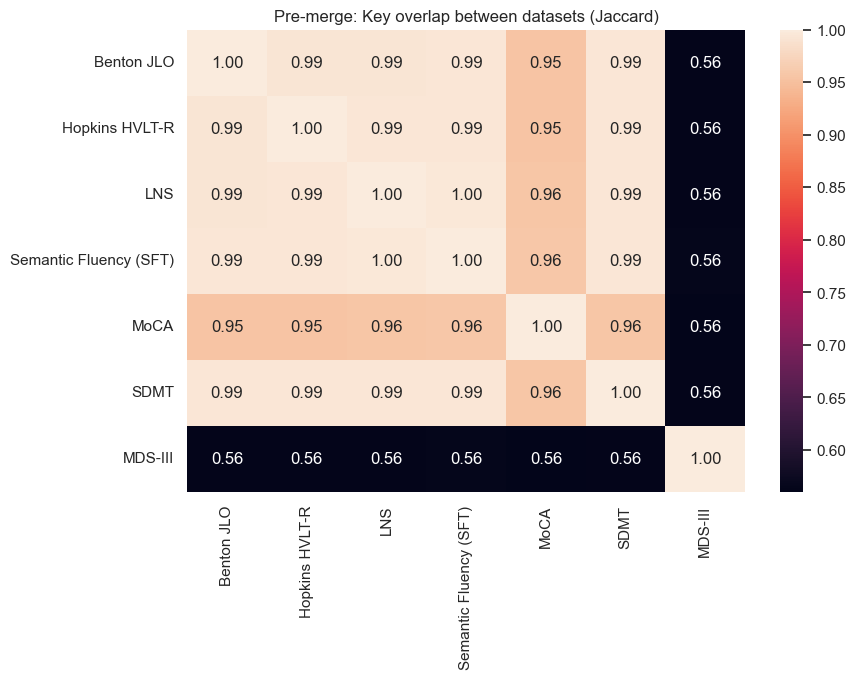

In [46]:
# ------------------------------
# Key overlap matrix (Jaccard similarity)
# ------------------------------

names = list(clean_dfs.keys())
key_sets = {n: set(clean_dfs[n]["PATNO_EVENT"]) for n in names}

overlap = pd.DataFrame(index=names, columns=names, dtype=float)

for a in names:
    for b in names:
        inter = len(key_sets[a] & key_sets[b])
        union = len(key_sets[a] | key_sets[b])
        overlap.loc[a, b] = inter / union if union > 0 else np.nan

plt.figure(figsize=(9, 6))
sns.heatmap(overlap, annot=True, fmt=".2f")
plt.title("Pre-merge: Key overlap between datasets (Jaccard)")
plt.show()

In [47]:
all_keys = set().union(*[set(df["PATNO_EVENT"]) for df in clean_dfs.values()])
common_keys = set.intersection(*[set(df["PATNO_EVENT"]) for df in clean_dfs.values()])

print("Keys in at least one dataset:", len(all_keys))
print("Keys common to ALL datasets:", len(common_keys))
print("Common-key percentage:", round(len(common_keys) / len(all_keys) * 100, 2), "%")

Keys in at least one dataset: 29352
Keys common to ALL datasets: 16074
Common-key percentage: 54.76 %


## 4. Merge, Normalize, and Save
### Normalization

To make features comparable across different score scales, I apply **z-score normalization** to numeric columns.
Non-numeric identifier columns (e.g., `PATNO_EVENT`) are kept unchanged.

In [58]:
# ------------------------------
# Merge + Normalize objective non-motor assessments (by PATNO_EVENT)
# ------------------------------

MERGE_HOW = "inner"

merge_order = [
    ("Benton JLO", df_Benton_clean),
    ("Hopkins HVLT-R", df_Hopkins_clean),
    ("LNS", df_LNS_clean),
    ("Semantic Fluency (SFT)", df_SFT_clean),
    ("MoCA", df_MoCA_clean),
    ("SDMT", df_SDMT_clean),
    ("MDS-III", df_MDS_III_clean),
]

# Print pre-merge shapes and unique keys
for name, df in merge_order:
    print(f"{name:22s} -> shape={df.shape}, unique_keys={df['PATNO_EVENT'].nunique()}")

# Merge sequentially
df_Objectives_merged = merge_order[0][1].copy()
print(f"\nStart: {merge_order[0][0]} -> shape={df_Objectives_merged.shape}, unique_keys={df_Objectives_merged['PATNO_EVENT'].nunique()}")

for name, df_next in merge_order[1:]:
    df_Objectives_merged = pd.merge(
        df_Objectives_merged,
        df_next,
        on="PATNO_EVENT",
        how=MERGE_HOW,
        validate="one_to_one"
    )
    print(f"After + {name:17s} -> shape={df_Objectives_merged.shape}, unique_keys={df_Objectives_merged['PATNO_EVENT'].nunique()}")

# Save NOT-normalized output
out_path_raw = "reports/Objectives_Features_All_Visit_not_normalized.csv"
df_Objectives_merged.to_csv(out_path_raw, index=False)
print("Saved (raw):", out_path_raw)

# ------------------------------
# Normalize (z-score) and save as CSV
# ------------------------------
# Normalize ONLY numeric columns; keep PATNO_EVENT unchanged
df_norm = df_Objectives_merged.copy()

num_cols = df_norm.select_dtypes(include=[np.number]).columns.tolist()

# If some numeric columns were read as object, convert them safely:
for c in df_norm.columns:
    if c != "PATNO_EVENT" and c not in num_cols:
        df_norm[c] = pd.to_numeric(df_norm[c], errors="ignore")

# Recompute numeric columns after conversion attempt
num_cols = df_norm.select_dtypes(include=[np.number]).columns.tolist()

# Z-score normalization: (x - mean) / std
# Protect against std=0 (constant column) to avoid division by zero
means = df_norm[num_cols].mean()
stds = df_norm[num_cols].std(ddof=0).replace(0, np.nan)

df_norm[num_cols] = (df_norm[num_cols] - means) / stds

# Optional: fill NaN caused by std=0 back to 0 (meaning "no variation")
df_norm[num_cols] = df_norm[num_cols].fillna(0)

out_path_norm = "reports/Objectives_Features_All_Visit_normalized_zscore.csv"
df_norm.to_csv(out_path_norm, index=False)
print("Saved (normalized):", out_path_norm)

df_norm.head()

Benton JLO             -> shape=(16383, 2), unique_keys=16383
Hopkins HVLT-R         -> shape=(16389, 5), unique_keys=16389
LNS                    -> shape=(16410, 2), unique_keys=16410
Semantic Fluency (SFT) -> shape=(16456, 2), unique_keys=16456
MoCA                   -> shape=(17080, 28), unique_keys=17080
SDMT                   -> shape=(16402, 2), unique_keys=16402
MDS-III                -> shape=(28713, 33), unique_keys=28713

Start: Benton JLO -> shape=(16383, 2), unique_keys=16383
After + Hopkins HVLT-R    -> shape=(16317, 6), unique_keys=16317
After + LNS               -> shape=(16282, 7), unique_keys=16282
After + Semantic Fluency (SFT) -> shape=(16274, 8), unique_keys=16274
After + MoCA              -> shape=(16243, 35), unique_keys=16243
After + SDMT              -> shape=(16226, 36), unique_keys=16226
After + MDS-III           -> shape=(16074, 68), unique_keys=16074
Saved (raw): reports/Objectives_Features_All_Visit_not_normalized.csv
Saved (normalized): reports/Objectives

,PATNO_EVENT,JLO_TOTRAW,DVT_TOTAL_RECALL,DVT_DELAYED_RECALL,DVT_RETENTION,DVT_RECOG_DISC_INDEX,LNS_TOTRAW,VLTANIM,MCAALTTM,MCACUBE,...,NP3PTRMR,NP3PTRML,NP3KTRMR,NP3KTRML,NP3RTARU,NP3RTALU,NP3RTARL,NP3RTALL,NP3RTALJ,NP3RTCON
0,3000_BL,-1.041877,-0.997906,-0.547686,0.025539,-0.807219,-1.197960,-1.125396,-0.343224,-0.587552,...,-0.238605,-0.227129,-0.198346,-0.270075,-0.448416,-0.222178,-0.07018,-0.061394,-0.04317,-0.414462
1,3000_V04,-1.041877,-0.307761,-0.547686,-0.488722,0.101284,-1.197960,-0.078886,-0.343224,-0.587552,...,-0.238605,-0.227129,-0.198346,-0.270075,-0.448416,-0.222178,-0.07018,-0.061394,-0.04317,-0.414462
2,3000_V06,-0.617673,-0.652834,-0.547686,-0.213225,-0.352968,-0.859423,-0.253305,-0.343224,-0.587552,...,-0.238605,-0.227129,-0.198346,-0.270075,-0.448416,-0.222178,-0.07018,-0.061394,-0.04317,-0.414462
3,3000_V08,-0.193470,-0.652834,-0.869958,-0.571371,0.101284,-0.859423,-1.474233,-0.343224,-0.587552,...,-0.238605,-0.227129,-0.198346,-0.270075,-0.448416,-0.222178,-0.07018,-0.061394,-0.04317,-0.414462
4,3000_V10,-0.617673,-0.997906,-0.547686,0.025539,-0.807219,-0.182348,-0.776560,-0.343224,-0.587552,...,0.555295,0.579515,0.482169,0.528231,-0.448416,-0.222178,-0.07018,-0.061394,-0.04317,-0.414462


# Some visualization for post-merge

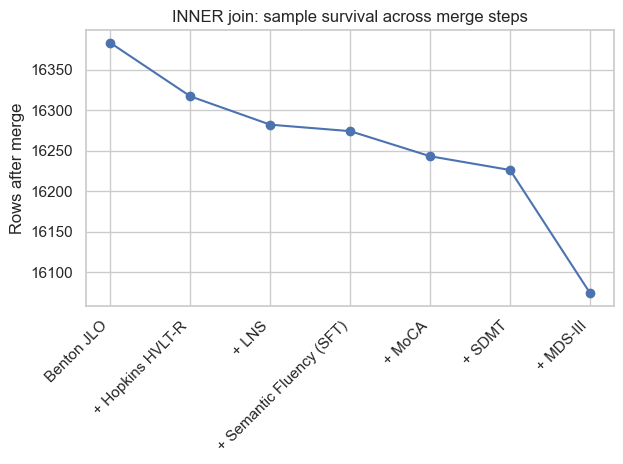

,step,rows,unique_keys
0,Benton JLO,16383,16383
1,+ Hopkins HVLT-R,16317,16317
2,+ LNS,16282,16282
3,+ Semantic Fluency (SFT),16274,16274
4,+ MoCA,16243,16243
5,+ SDMT,16226,16226
6,+ MDS-III,16074,16074


In [50]:
# ------------------------------
# Post-merge visualization (INNER join)
# ------------------------------

# 1) Row survival across merge steps (inner join attrition)
merge_steps = []
df_tmp = merge_order[0][1].copy()
merge_steps.append({"step": merge_order[0][0], "rows": df_tmp.shape[0], "unique_keys": df_tmp["PATNO_EVENT"].nunique()})

for name, df_next in merge_order[1:]:
    df_tmp = pd.merge(df_tmp, df_next, on="PATNO_EVENT", how="inner", validate="one_to_one")
    merge_steps.append({"step": f"+ {name}", "rows": df_tmp.shape[0], "unique_keys": df_tmp["PATNO_EVENT"].nunique()})

df_merge_steps = pd.DataFrame(merge_steps)

plt.figure()
plt.plot(range(len(df_merge_steps)), df_merge_steps["rows"], marker="o")
plt.xticks(range(len(df_merge_steps)), df_merge_steps["step"], rotation=45, ha="right")
plt.ylabel("Rows after merge")
plt.title("INNER join: sample survival across merge steps")
plt.tight_layout()
plt.show()

df_merge_steps

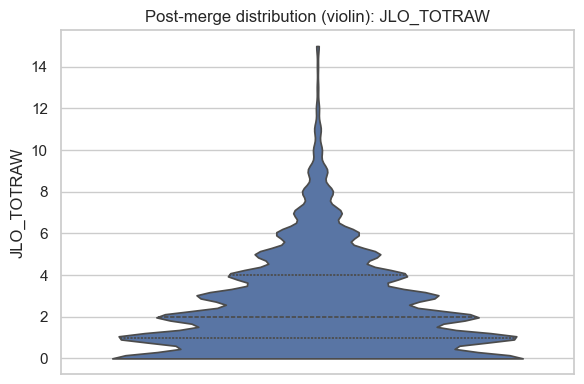

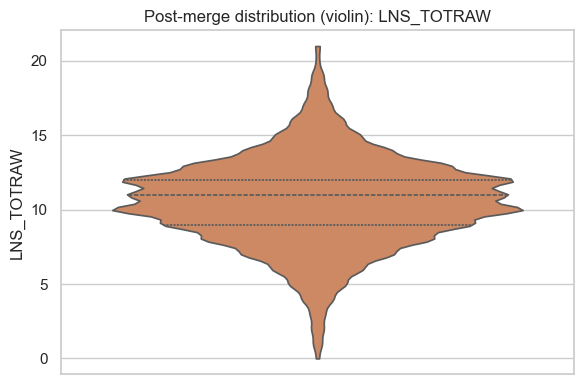

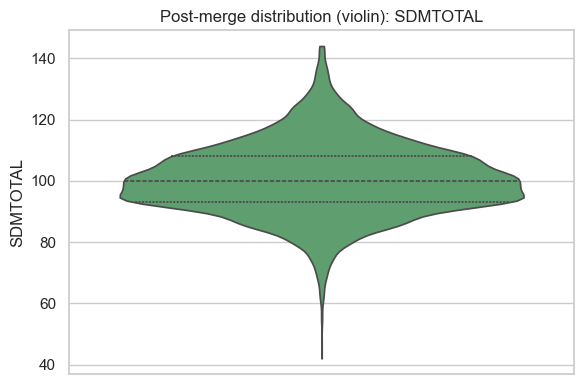

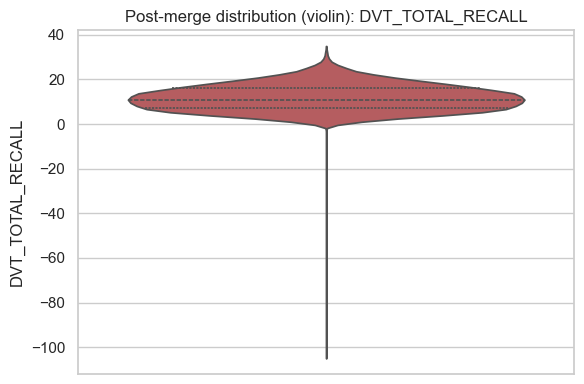

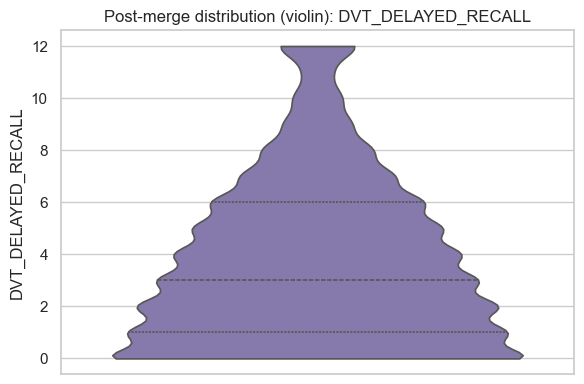

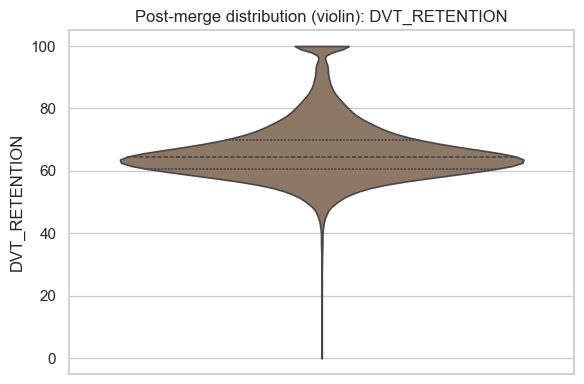

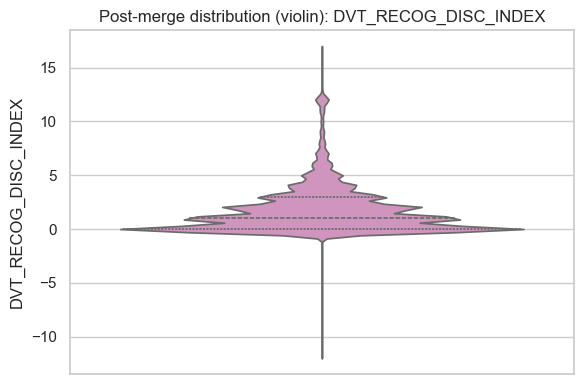

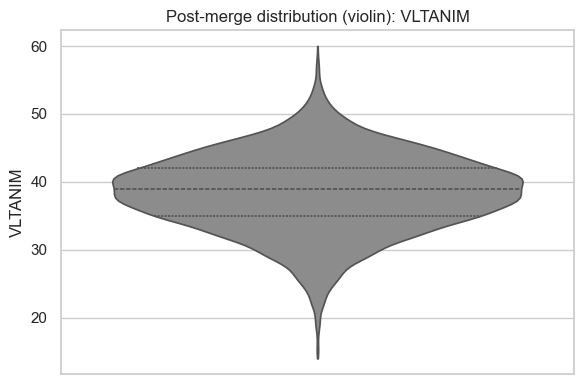

In [61]:
# QC distributions: main derived scores (VIOLIN plots with deep colors)

qc_cols = [
    "JLO_TOTRAW",
    "LNS_TOTRAW",
    "SDMTOTAL",
    "DVT_TOTAL_RECALL",
    "DVT_DELAYED_RECALL",
    "DVT_RETENTION",
    "DVT_RECOG_DISC_INDEX",
    "VLTANIM", "VLTVEG", "VLTFRUIT",
]

qc_cols = [c for c in qc_cols if c in df_Objectives_merged.columns]

# Use a deep palette (dark, saturated colors)
palette = sns.color_palette("deep", n_colors=len(qc_cols))

for i, c in enumerate(qc_cols):
    s = pd.to_numeric(df_Objectives_merged[c], errors="coerce").dropna()
    plot_df = pd.DataFrame({c: s})

    plt.figure(figsize=(6, 4))
    sns.violinplot(
        y=c,
        data=plot_df,
        inner="quartile",
        cut=0,
        color=palette[i]   # deep color per feature
    )
    plt.title(f"Post-merge distribution (violin): {c}")
    plt.ylabel(c)
    plt.tight_layout()
    plt.show()

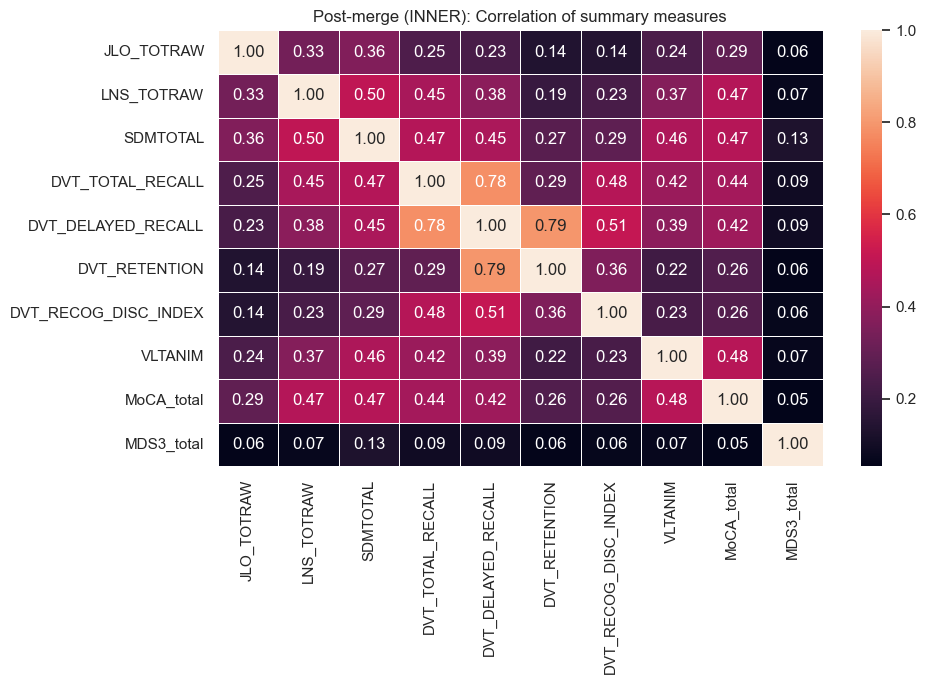

In [56]:
# 4) Create simple TOTAL scores (MoCA total + MDS-III total) for cleaner plots/correlation
df_viz = df_Objectives_merged.copy()

# MoCA total (sum of available MCA* columns in merged df)
moca_items = [c for c in df_viz.columns if c.startswith("MCA") and c != "PATNO_EVENT"]
if len(moca_items) > 0:
    df_viz[moca_items] = df_viz[moca_items].apply(pd.to_numeric, errors="coerce")
    df_viz["MoCA_total"] = df_viz[moca_items].sum(axis=1, min_count=1)

# MDS-III total (sum of NP3* columns)
mds_items = [c for c in df_viz.columns if c.startswith("NP3")]
if len(mds_items) > 0:
    df_viz[mds_items] = df_viz[mds_items].apply(pd.to_numeric, errors="coerce")
    df_viz["MDS3_total"] = df_viz[mds_items].sum(axis=1, min_count=1)
corr_cols = [
    "JLO_TOTRAW", "LNS_TOTRAW", "SDMTOTAL",
    "DVT_TOTAL_RECALL", "DVT_DELAYED_RECALL", "DVT_RETENTION", "DVT_RECOG_DISC_INDEX",
    "VLTANIM", "VLTVEG", "VLTFRUIT",
    "MoCA_total", "MDS3_total"
]
corr_cols = [c for c in corr_cols if c in df_viz.columns]

corr_df = df_viz[corr_cols].apply(pd.to_numeric, errors="coerce")
corr = corr_df.corr()

plt.figure(figsize=(10, 7))
sns.heatmap(corr, annot=True, fmt=".2f", linewidths=0.5)
plt.title("Post-merge (INNER): Correlation of summary measures")
plt.tight_layout()
plt.show()